In [1]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e
import random

In [2]:
from keras import Model
from keras.models import load_model
import numpy as np
import os
import pandas as pd


# dense1_layer_model.summary()

2021-11-24 21:05:05.205035: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-24 21:05:05.205074: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'non_gene_4':'./data/gene/non_gene_4.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'bam4':'./data/051_4.bam',
    'bam5':'./data/051_5.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed',
    'ATAC_hema_1':'./data/gene/ATAC_hema_1.bed',
    'ATAC_hema_2':'./data/gene/ATAC_hema_2.bed'
    }
TSS_HK = []
# TSS_test_x = []
# with open(dic['ATAC_hema_1'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1']:
#             TSS_HK.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
with open(dic['TSS_HK'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['1','2','3']:
            TSS_HK.append(TSS(ll[0], int(int(ll[1])+1000)))
            
        


TSS_NonGene = []
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))
# TSS_NonGene_4 = []
# with open(dic['non_gene_4'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_NonGene_4.append(TSS(ll[0], int(ll[1])+int(1000)))


bamfile = ps.AlignmentFile(dic['bam123'],'rb')

# TSS_test_x += TSS_NonGene[len(TSS_HK):len(TSS_HK)+len(TSS_test_x)]
# perm_test = random.sample(range(len(TSS_test_x)),len(TSS_test_x))
# TSS_test_x = np.array(TSS_test_x)
# TSS_test_y = np.array(TSS_test_y)
# TSS_test_x = TSS_test_x[perm_test[:len(perm_test)]]
# TSS_test_y = TSS_test_y[perm_test[:len(perm_test)]]



TSS_NonGene = TSS_NonGene[:len(TSS_HK)]

TSSes_x = TSS_HK + TSS_NonGene
TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
TSSes_x = np.array(TSSes_x)
TSSes_y = np.array(TSSes_y)
TSSes_x = TSSes_x[perm[:len(perm)]]
TSSes_y = TSSes_y[perm[:len(perm)]]

In [62]:
print(TSS_HK[0].pos)

894636


In [4]:
'''lstm_input'''
up = 1000
down = 1000
# feature_matrix = []
# for j, tss in enumerate(TSSes_x):
#     chrom = tss.chrom
#     start = tss.pos - up
#     end = tss.pos + down
#     up_end = np.zeros(up+down, dtype= int)
#     down_end = np.zeros(up+down, dtype= int)
#     long = np.zeros(up+down, dtype= int)
#     short = np.zeros(up+down, dtype= int)
#     cov = np.zeros(up+down, dtype= int)
#     for r in bamfile.fetch(chrom[-1], start-500, end + 500):
#         if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
#             if r.reference_start + abs(r.isize) < start:
#                 continue
#             if r.reference_start >= end:
#                 continue
#             # ss = max(0, r.reference_start - start)
#             # ee = min(r.reference_start - start + abs(r.isize), end - start)
#             ss = r.reference_start - start
#             ee = r.reference_start - start + abs(r.isize)
#             if ss >= 0:
#                 up_end[ss] += 1
#             else:
#                 ss = 0
#             if ee < end - start:
#                 down_end[ee] += 1
#             else:
#                 ee = end - start
#             for i in range(ss, ee):
#                 cov[i] += 1
#             if 200 >= abs(r.isize) > 130:
#                 for i in range(ss, ee):
#                     long[i] += 1
#             if abs(r.isize) <= 130:
#                 for i in range(ss, ee):
#                     short[i] += 1
#     k = 0
#     win = 40
#     feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
#     while k < (up+down)/win:
#         ss = k * win
#         ee = k * win + win
#         ff = []
#         ff.append(int(round(np.mean(cov[ss:ee]))))
#         ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
#         ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
#         wps = 0
#         for r in bamfile.fetch(chrom[-1], ss+start, ee+start):
#             if r.reference_start <= ss+start and r.reference_start+abs(r.isize) >= ee + start:
#                 wps += 1
#             elif ee + start > r.reference_start > ss + start:
#                 wps -= 1
#             elif ss+start < r.reference_start + abs(r.isize) < ee + start:
#                 wps -= 1
#         ff.append(int(wps))
#         feature_win[k] = np.array(ff)
#         k =  k + 1
#     feature_matrix.append(feature_win)
# feature_matrix = np.array(feature_matrix)
win=40
feature_matrix = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        ff.append(int(round(np.mean(wps[ss:ee]))))
        feature_win[k] = np.array(ff)
        k = k + 1
    feature_matrix.append(feature_win)
    # ff = [cov,long-short,abs(up_end-down_end),wps]
    # feature_matrix.append([[row[i]for row in ff] for i in range(len(ff[0]))])
feature_matrix = np.array(feature_matrix)
# lstm_x = []
# for mat in feature_matrix:
#     lstm_x.append(mat)
# lstm_x = np.array(lstm_x)
lstm_x = feature_matrix


In [5]:
'''cnn_input'''
raw_data = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    distribution_matrix = np.zeros((int((up+down)/50), 40), dtype=int)
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse and 50 < abs(r.isize) < 250:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            if r.reference_start < start:
                continue
            if r.reference_start + abs(r.isize) > end:
                continue
            ss = max(0, r.reference_start - start)
            relative_isize = abs(r.isize)-50
            distribution_matrix[ss//50,relative_isize//5] += 1
    raw_data.append(distribution_matrix)
raw_data = np.array(raw_data)
cnn_x = []
for mat in raw_data:
    cnn_x.append(mat)
cnn_x = np.array(cnn_x)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# y_train = keras.utils.to_categorical(train_y,num_classes=2)
# y_test = keras.utils.to_categorical(train_y,num_classes=2)
input_size = lstm_x.shape[2]#4
time_steps = lstm_x.shape[1]#50

model = keras.Sequential()
model.add(keras.layers.Convolution1D(filters=100,kernel_size=10,input_shape=(time_steps,input_size),activation='relu',strides=1,padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2,strides=2))
model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Convolution1D(filters=64, kernel_size=2, strides=2, activation='relu', padding='same',input_shape=(time_steps, input_size)))
# model.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
# model.add(keras.layers.Convolution1D(filters=32, kernel_size=2, strides=2, activation='relu', padding='same'))
# model.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
# model.add(keras.layers.Convolution1D(filters=32, kernel_size=2, strides=2, activation='relu', padding='same'))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True),name='0'))
# model.add(keras.layers.LSTM(40,return_sequences=True,input_shape=(time_steps, input_size)))
model.add(keras.layers.Conv1D(filters=100, kernel_size=3, activation='relu',strides=1,padding='same',name='1'))
model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2,name='2'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(750, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='3'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='4'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='5'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='6'))

# print(model.summary())

adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
# print(model.summary())
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(lstm_x, TSSes_y, epochs=20, batch_size=128, validation_split=0.1)
# loss, accuracy = model.evaluate(test_x, test_y)
model.save('./lstm.h5')
# print(loss, accuracy)

Epoch 1/20
12/12 [==============================] - 3s 94ms/step - loss: 0.6712 - accuracy: 0.5963 - val_loss: 0.5625 - val_accuracy: 0.7927
Epoch 2/20
12/12 [==============================] - 1s 48ms/step - loss: 0.5384 - accuracy: 0.7646 - val_loss: 0.3547 - val_accuracy: 0.9085
Epoch 3/20
12/12 [==============================] - 1s 49ms/step - loss: 0.3880 - accuracy: 0.8616 - val_loss: 0.2783 - val_accuracy: 0.8841
Epoch 4/20
12/12 [==============================] - 1s 47ms/step - loss: 0.3091 - accuracy: 0.8887 - val_loss: 0.2762 - val_accuracy: 0.8780
Epoch 5/20
12/12 [==============================] - 1s 48ms/step - loss: 0.2783 - accuracy: 0.8901 - val_loss: 0.2591 - val_accuracy: 0.9146
Epoch 6/20
12/12 [==============================] - 1s 51ms/step - loss: 0.2668 - accuracy: 0.9098 - val_loss: 0.2476 - val_accuracy: 0.9146
Epoch 7/20
12/12 [==============================] - 1s 55ms/step - loss: 0.2571 - accuracy: 0.9057 - val_loss: 0.2378 - val_accuracy: 0.9207
Epoch 8/20
12

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random
cnn_x = cnn_x.reshape(cnn_x.shape[0], cnn_x.shape[1], cnn_x.shape[2], 1)
time_steps = cnn_x.shape[1]
input_size = cnn_x.shape[2]
model = keras.models.Sequential()

model.add(layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(time_steps, input_size,1),name='0'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D(strides=(2,2),pool_size=(2,2),name='1'))
model.add(layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),padding='same',name='2'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D(strides=(2,2),pool_size=(2,2),name='3'))
model.add(layers.Flatten())
model.add(layers.Dense(750,activation='relu', kernel_regularizer=None, bias_regularizer=None,name='4'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(300,activation='relu',kernel_regularizer=None, bias_regularizer=None,name='5'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16,activation='relu',kernel_regularizer=None, bias_regularizer=None,name='6'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid',kernel_regularizer=None, bias_regularizer=None,name='7'))
adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(cnn_x, TSSes_y, epochs=20, batch_size=128, validation_split=0.1)
# history = model.fit(cnn_x, TSSes_y, epochs=20, batch_size=128, validation_split=0.1,
#                         callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./' + 'weight.h5', save_best_only=True)],
#                         shuffle=True, verbose=2)
# loss, accuracy = model.evaluate(test_x, test_y)
model.save( './cnn.h5')

Epoch 1/20
12/12 [==============================] - 2s 113ms/step - loss: 0.6658 - accuracy: 0.5902 - val_loss: 0.5949 - val_accuracy: 0.7439
Epoch 2/20
12/12 [==============================] - 1s 100ms/step - loss: 0.5542 - accuracy: 0.7571 - val_loss: 0.4377 - val_accuracy: 0.8659
Epoch 3/20
12/12 [==============================] - 1s 115ms/step - loss: 0.4103 - accuracy: 0.8609 - val_loss: 0.3109 - val_accuracy: 0.9146
Epoch 4/20
12/12 [==============================] - 1s 117ms/step - loss: 0.3143 - accuracy: 0.8887 - val_loss: 0.2583 - val_accuracy: 0.9207
Epoch 5/20
12/12 [==============================] - 1s 105ms/step - loss: 0.2743 - accuracy: 0.8982 - val_loss: 0.2408 - val_accuracy: 0.9207
Epoch 6/20
12/12 [==============================] - 1s 104ms/step - loss: 0.2384 - accuracy: 0.9132 - val_loss: 0.2383 - val_accuracy: 0.9207
Epoch 7/20
12/12 [==============================] - 1s 102ms/step - loss: 0.2245 - accuracy: 0.9233 - val_loss: 0.2456 - val_accuracy: 0.9207
Epoch 

In [ ]:
print(model.summary())

In [9]:
model_cnn = load_model('./cnn.h5')
dense1_layer_model = Model(inputs=model_cnn.input, outputs=model_cnn.layers[-2].output)
dense1_layer_model.trainable = False
model_lstm = load_model('./lstm.h5')
dense2_layer_model = Model(inputs=model_lstm.input, outputs=model_lstm.layers[-2].output)
dense2_layer_model.trainable = False
# positive = np.array([cnn_x[i] for i in range(len(lstm_x)) if TSSes_y[i] == 1])
# negetive = np.array([cnn_x[i] for i in range(len(lstm_x)) if TSSes_y[i] == 0])

In [ ]:
# from keras import backend as K
# import tensorflow as tf
# preds = model_cnn.predict(np.array(positive))
# index = np.argmax(preds[0])
# target_output = model_cnn.output[:,index]
# last_conv_layer = model.get_layer('2')
# # grads = tf.keras.backend.gradients(target_output, last_conv_layer.output)[0]
# with tf.GradientTape() as gtape:
#     grads = gtape.gradient(target_output, last_conv_layer.output)
# pooled_grads = K.mean(grads, axis=(0,1,2))
# iterate = K.function([model_cnn.input],[pooled_grads, last_conv_layer.output[0]])
# pooled_grads_value, conv_layer_output_value = iterate([positive])


In [89]:
# import matplotlib.pyplot as plt
# inp = model_cnn.input
# out_conv = model_cnn.get_layer('1').output
# in_model = Model(inputs=inp, outputs=out_conv)
# outp = in_model.predict(cnn_x)
# outp = np.transpose(outp,(0,3,1,2))
# positive = [outp[i] for i in range(len(lstm_x)) if TSSes_y[i] == 1]
# negetive = [outp[i] for i in range(len(lstm_x)) if TSSes_y[i] == 0]

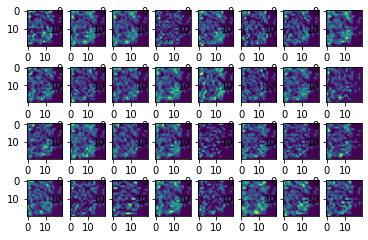

In [90]:
# for i in range(32):
#     plt.subplot(4,8,i+1)
#     plt.imshow(positive[0][i])
# plt.show()

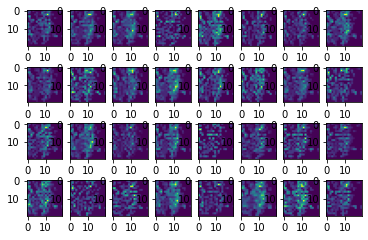

In [91]:
# for i in range(32):
#     plt.subplot(4,8,i+1)
#     plt.imshow(negetive[0][i])
# plt.show()

In [10]:
pred_lstm_y = dense2_layer_model.predict(lstm_x)
pred_cnn_y = dense1_layer_model.predict(cnn_x)

# positive = [pred_cnn_y[i] for i in range(len(lstm_x)) if TSSes_y[i] == 1]
# negetive = [pred_cnn_y[i] for i in range(len(lstm_x)) if TSSes_y[i] == 0]
# import pandas as pd
# df1 = pd.DataFrame(positive)
# df2 = pd.DataFrame(negetive)
# df1.to_csv('./df1.csv')
# df2.to_csv('./df2.csv')

# pred_y = []
pred_x = np.append(pred_lstm_y,pred_cnn_y,axis=1)
# for i in range(len(pred_lstm_y)):
#     pred_y.append([pred_lstm_y[i],pred_cnn_y[i]])
# pred_y = np.array(pred_y)
train_x = pred_x
train_y = TSSes_y

In [25]:
print(pred_x.shape)

(2752, 32)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model0 = keras.models.Sequential()
model0.add(layers.Dense(300,activation='relu',kernel_regularizer=None, bias_regularizer=None,input_shape=(1,32)))
model0.add(layers.Dropout(0.2))
model0.add(layers.Dense(1, activation='sigmoid',kernel_regularizer=None, bias_regularizer=None))
adam = keras.optimizers.Adam(lr=1e-4)
model0.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model0.fit(train_x, train_y, epochs=20, batch_size=128, validation_split=0.1,
                        callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./' + 'weight.h5', save_best_only=True)],
                        shuffle=True, verbose=2)
model0.save('./lstm_cnn_dense.h5')

In [69]:
print(pred_lstm_y.shape)
print(pred_cnn_y.shape)
print(pred_x.shape)

(1638, 16)
(1638, 16)
(1638, 32)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
import random
import joblib
from sklearn import tree




# train_x = pred_x[:1000]
# train_y = TSSes_y[:1000]
# test_x = pred_x[1000:]
# test_y = TSSes_y[1000:]
train_x = pred_x
train_y = TSSes_y

# scaler = MinMaxScaler()
# feature = scaler.fit_transform(pred_x)

svcClf = SVC(C=1.0, kernel='rbf')
svcClf.fit(train_x,train_y)
joblib.dump(svcClf,'./svm.pkl')

# pred_svm = svcClf.predict(test_x)
# num = len(pred_svm)
# accuracy_svm = len([1 for i in range(num) if test_y[i] == pred_svm[i]]) / float(num)
# print("svm,acc:",accuracy_svm)

rfClf = RandomForestClassifier(n_estimators=400,criterion='gini')
rfClf.fit(train_x, train_y)
joblib.dump(rfClf,'./rf.pkl')
# pred_rf = rfClf.predict(test_x)
# num = len(pred_rf)
# accuracy_rf = len([1 for i in range(num) if test_y[i] == pred_rf[i]]) / float(num)
# print("rf,acc:",accuracy_rf)

treeClf = tree.DecisionTreeClassifier()
treeClf.fit(train_x, train_y)
joblib.dump(treeClf,'./tree.pkl')

['./tree.pkl']